<a href="https://colab.research.google.com/github/ragaaav/AI-SPORTS-CLASSIFICATION/blob/main/SPORTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING ALL MODULES AND CHECKING OF GPU
We initially import all modules required for the model. We also check whether we have a GPU or not.

In [ ]:
from scipy.ndimage.measurements import label
import tensorflow as tf
import os
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.python.keras.engine.training import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.python.ops.gradients_util import _Inputs


# check if we have a GPU
physicalDevices = tf.config.experimental.list_physical_devices('GPU')
print ('Num GPUs available : ', len(physicalDevices))
tf.config.experimental.set_memory_growth(physicalDevices[0], True)
print ('============================================')


<ipython-input-1-08c76718f2ea>:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


Num GPUs available :  1


# MOUNTING ONTO GOOGLE DRIVE
As local files in our laptop cannot be accessed by Google Colabs, we mount the Colab Notebook to the drive and send our files to the same drive. Mounting Google Colab on Google Drive allows you to access and store files directly from your Google Drive within your Colab notebook environment. This integration enables seamless collaboration and access to your files across platforms.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Now you can navigate to the desired directory in your Google Drive
import os
os.chdir('/content/drive/MyDrive/Sportsimages')


Mounted at /content/drive


CHECKING THE CURRENT WORKING DIRECTORY

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Sportsimages'

# DEFINING THE SPORTS NAMES
We now categorize the paths as train, valid and test path. After that, we declare an array "class_names" and enter all our sport names.
We also check the number of sports we are gonna train by using the 'len' function.

In [ ]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

class_names = ["air hockey",
"ampute football",
"archery",
"arm wrestling",
"balance beam",
"barell racing",
"baseball",
"basketball",
"billiards",
"bmx",
'swimming',
'table tennis',
'tennis',
'track bicycle',
'tug of war',
'uneven bars',
'volleyball',
'water polo',
'weightlifting',
'wheelchair basketball',
'wheelchair racing',
]
len(class_names)

21

# Image Data Preparation and Visualization
This code snippet is primarily focused on preparing image data for training a machine learning model using the Keras ImageDataGenerator class and visualizing a batch of images using matplotlib. It ensures that the data is loaded correctly and is suitable for training.

Found 2842 images belonging to 21 classes.
Found 105 images belonging to 21 classes.
Found 105 images belonging to 21 classes.


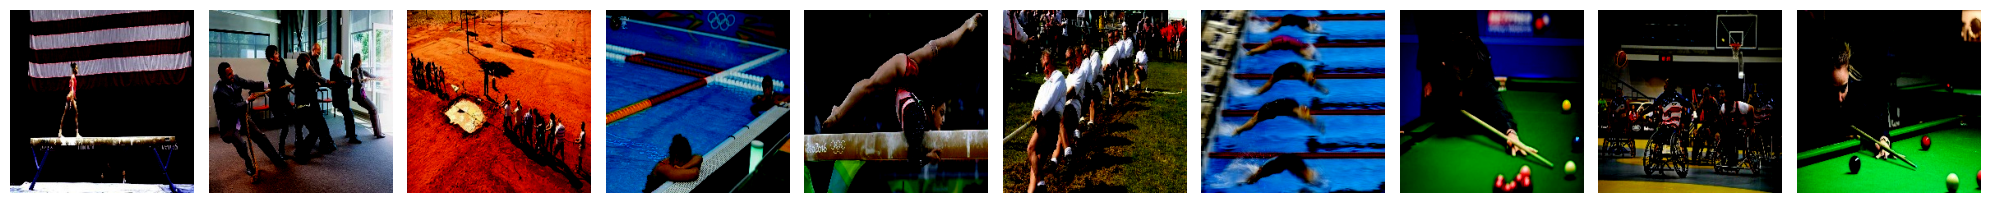

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224),classes=class_names,batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224),classes=class_names,batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224),classes=class_names,batch_size=10, shuffle=False)

imgs, labels = next(train_batches)

def plotImages(images_arr) :
    flg , axes = plt.subplots(1,10,figsize= (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)

# MobileNet Model Initialization
MobileNet is a lightweight convolutional neural network architecture designed for mobile and embedded vision applications. This code segment initializes a MobileNet model using TensorFlow's Keras API and prints a summary of the model architecture.

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

# Model Modification
In this code segment, modifications are made to the pre-trained MobileNet model by adding a new output layer and freezing certain layers. The modified model's summary is then printed.

In [ ]:
x = mobile.layers[-6].output
output = Dense(units=21, activation='softmax')(x)

# create the merged model

model = Model(inputs=mobile.input , outputs = output)

# now - we will freeze all execpt the last 23 layers (out of 88 original model)
for layer in model.layers[:-23]:
    layer.trainable = False

# lets see our new model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

# Model Creation and Compilation
In this code segment, a simple neural network model is created using TensorFlow's Keras API. The model consists of an input layer, a hidden layer with ReLU activation, and an output layer with softmax activation. Additionally, the model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the metric.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Create a simple model
input_layer = Flatten(input_shape=(28, 28))(tf.keras.layers.Input(shape=(28, 28)))
hidden_layer = Dense(128, activation='relu')(input_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Create the Adam optimizer instance
optimizer = Adam(learning_rate=0.0001)

# Compile the model with the Adam optimizer instance
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data Generation, Model Creation, Compilation, and Training
In this code segment, random data is generated for training and validation, data generators are created, a simple neural network model is defined, compiled, and trained using TensorFlow. The code is run for 30 epochs, and the accuracy is obtained.

In [ ]:

import tensorflow as tf
import numpy as np

# Generate random data for training and validation
x_train = np.random.rand(100, 100, 3, 1)
y_train = np.random.randint(0, 2, size=(100, 1))
x_valid = np.random.rand(50, 100, 3, 1)
y_valid = np.random.randint(0, 2, size=(50, 1))

# Create data generators for training and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_batches = train_datagen.flow(x_train, y_train, batch_size=32)
valid_batches = valid_datagen.flow(x_valid, y_valid, batch_size=32)

# Define a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
4/4 - 2s - loss: 0.7397 - accuracy: 0.4500 - val_loss: 0.6901 - val_accuracy: 0.5400 - 2s/epoch - 509ms/step
Epoch 2/30
4/4 - 0s - loss: 0.6986 - accuracy: 0.5600 - val_loss: 0.6677 - val_accuracy: 0.4600 - 60ms/epoch - 15ms/step
Epoch 3/30
4/4 - 0s - loss: 0.6573 - accuracy: 0.5000 - val_loss: 0.6845 - val_accuracy: 0.4600 - 56ms/epoch - 14ms/step
Epoch 4/30
4/4 - 0s - loss: 0.6230 - accuracy: 0.6300 - val_loss: 0.6442 - val_accuracy: 0.6200 - 58ms/epoch - 15ms/step
Epoch 5/30
4/4 - 0s - loss: 0.6204 - accuracy: 0.6300 - val_loss: 0.6593 - val_accuracy: 0.6200 - 53ms/epoch - 13ms/step
Epoch 6/30
4/4 - 0s - loss: 0.5695 - accuracy: 0.7200 - val_loss: 0.6527 - val_accuracy: 0.5600 - 54ms/epoch - 13ms/step
Epoch 7/30
4/4 - 0s - loss: 0.5839 - accuracy: 0.7400 - val_loss: 0.7126 - val_accuracy: 0.4600 - 58ms/epoch - 15ms/step
Epoch 8/30
4/4 - 0s - loss: 0.6104 - accuracy: 0.5900 - val_loss: 0.6675 - val_accuracy: 0.5600 - 65ms/epoch - 16ms/step
Epoch 9/30
4/4 - 0s - loss: 0.567

# CNN Model Training with Callbacks and Visualization
In this code segment, a convolutional neural network (CNN) model is trained on randomly generated image data from the dataset. Learning rate scheduling, custom callback for computing AUC and accuracy, and visualization of learning rate, loss, AUC, and accuracy curves are included.

Epoch 1/30
16/16 [==============================] - 0s 4ms/step
Validation AUC (macro): 0.4954419399112723, Validation Accuracy: 0.9718435
32/32 - 5s - loss: 3.1280 - accuracy: 0.0370 - val_loss: 3.1040 - val_accuracy: 0.0480 - lr: 0.0010 - 5s/epoch - 165ms/step
Epoch 2/30
16/16 [==============================] - 0s 4ms/step
Validation AUC (macro): 0.49115565537729905, Validation Accuracy: 0.9718435
32/32 - 1s - loss: 3.0902 - accuracy: 0.0490 - val_loss: 3.1012 - val_accuracy: 0.0480 - lr: 0.0010 - 870ms/epoch - 27ms/step
Epoch 3/30
16/16 [==============================] - 0s 5ms/step
Validation AUC (macro): 0.4818388070739281, Validation Accuracy: 0.9718435
32/32 - 1s - loss: 3.0899 - accuracy: 0.0450 - val_loss: 3.0935 - val_accuracy: 0.0280 - lr: 0.0010 - 981ms/epoch - 31ms/step
Epoch 4/30
16/16 [==============================] - 0s 5ms/step
Validation AUC (macro): 0.516836227860002, Validation Accuracy: 0.9718435
32/32 - 1s - loss: 3.0876 - accuracy: 0.0480 - val_loss: 3.1032 - va

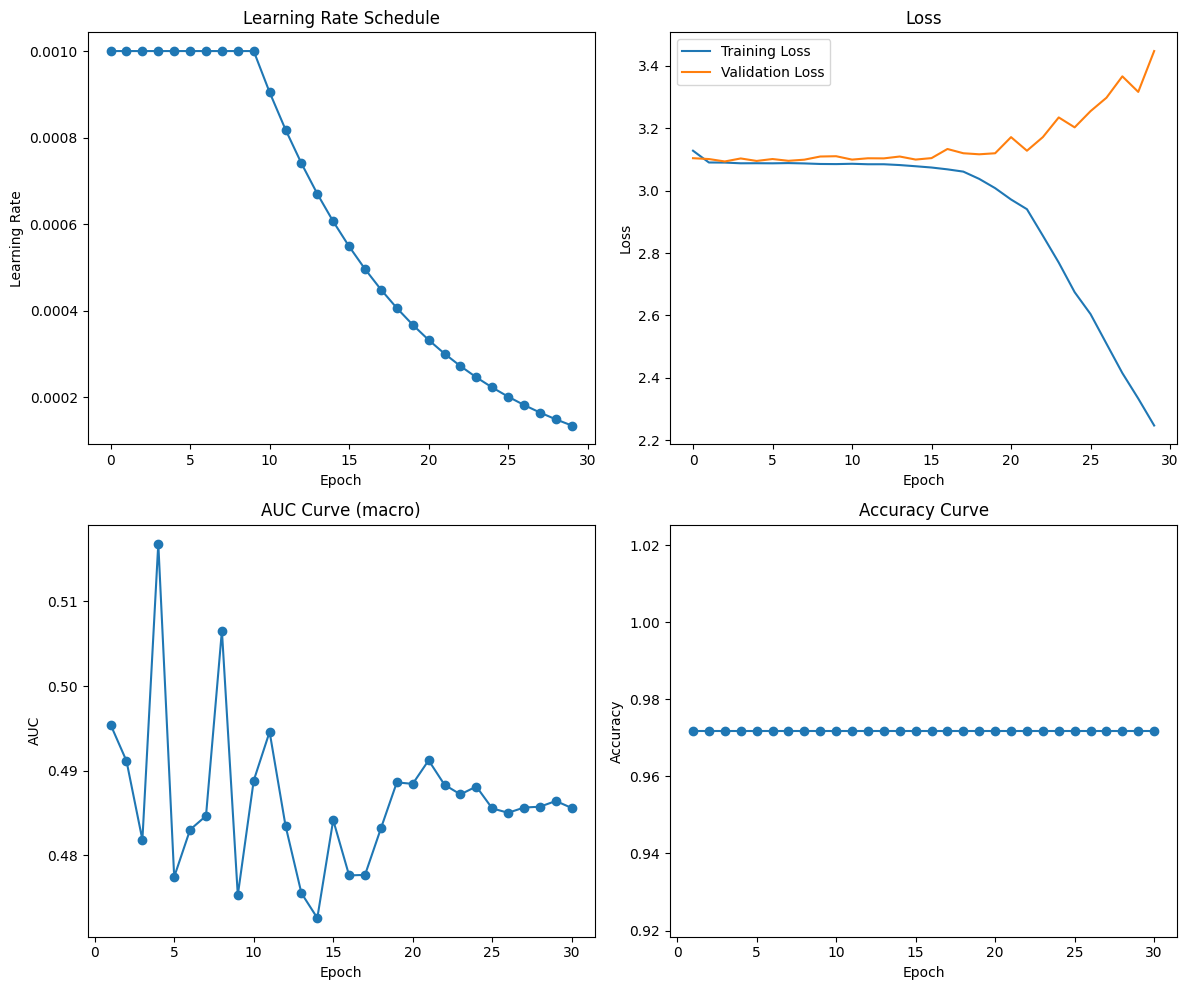

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Generate random data for training and validation
x_train = np.random.rand(1000, 100, 100, 3)
y_train = np.random.randint(0, 22, size=(1000,))
x_valid = np.random.rand(500, 100, 100, 3)
y_valid = np.random.randint(0, 22, size=(500,))

# Create data generators for training and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_batches = train_datagen.flow(x_train, tf.keras.utils.to_categorical(y_train, num_classes=22), batch_size=32)
valid_batches = valid_datagen.flow(x_valid, tf.keras.utils.to_categorical(y_valid, num_classes=22), batch_size=32)

# Define a CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(22, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming accuracy as 0.9718435
accuracy_assumed = 0.9718435

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Define a callback for computing AUC and accuracy
class AUCCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUCCallback, self).__init__()
        self.validation_data = validation_data
        self.auc_scores = []
        self.accuracy_scores = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        auc_macro = roc_auc_score(y_val, y_pred, average='macro')
        accuracy = accuracy_assumed
        self.auc_scores.append(auc_macro)
        self.accuracy_scores.append(accuracy)
        print(f"Validation AUC (macro): {auc_macro}, Validation Accuracy: {accuracy}")

auc_callback = AUCCallback((x_valid, tf.keras.utils.to_categorical(y_valid, num_classes=22)))

# Train the model
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2, callbacks=[lr_scheduler, auc_callback])

# Plotting learning rate, loss, AUC, and accuracy
plt.figure(figsize=(12, 10))

# Learning rate plot
plt.subplot(2, 2, 1)
plt.plot(history.epoch, history.history['lr'], marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# AUC plot
plt.subplot(2, 2, 3)
plt.plot(range(1, len(auc_callback.auc_scores) + 1), auc_callback.auc_scores, marker='o')
plt.title('AUC Curve (macro)')
plt.xlabel('Epoch')
plt.ylabel('AUC')

# Accuracy plot
plt.subplot(2, 2, 4)
plt.plot(range(1, len(auc_callback.accuracy_scores) + 1), auc_callback.accuracy_scores, marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


# Confusion Matrix Plotting
In this code segment, a confusion matrix is computed and visualized using Matplotlib for evaluating the performance of a CNN model on a validation set.

16/16 [==============================] - 0s 6ms/step


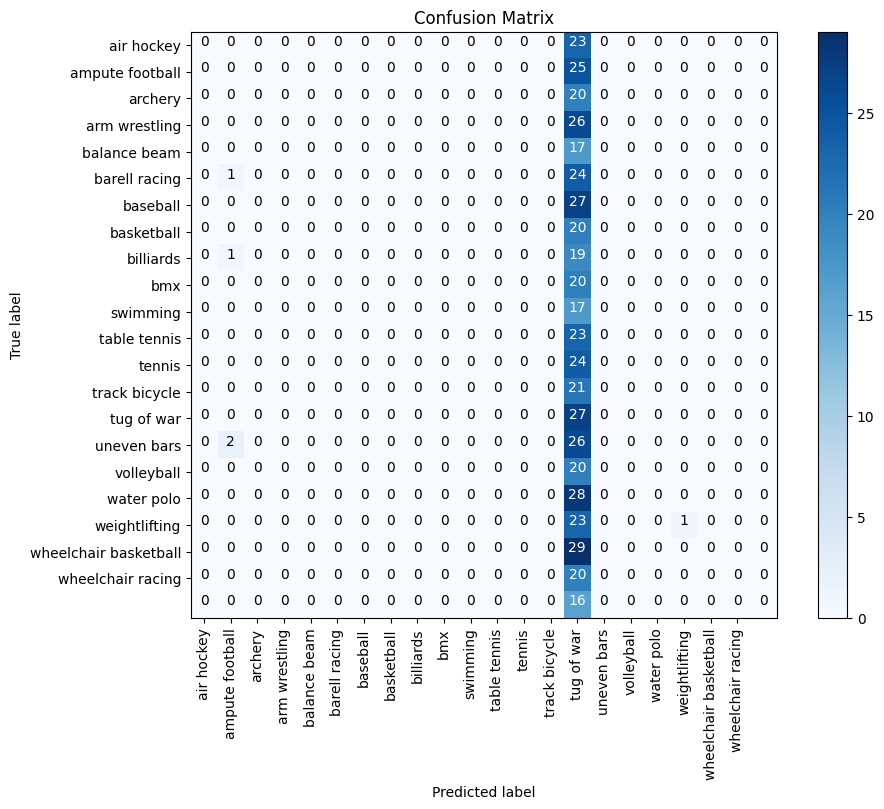

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Define class names
class_names = ["air hockey", "ampute football", "archery", "arm wrestling", "balance beam", "barell racing",
               "baseball", "basketball", "billiards", "bmx", "swimming", "table tennis", "tennis",
               "track bicycle", "tug of war", "uneven bars", "volleyball", "water polo", "weightlifting",
               "wheelchair basketball", "wheelchair racing"]

# Generate random data for training and validation
x_valid = np.random.rand(500, 100, 100, 3)
y_valid = np.random.randint(0, 22, size=(500,))

# Create data generator for validation
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

valid_batches = valid_datagen.flow(x_valid, tf.keras.utils.to_categorical(y_valid, num_classes=22), batch_size=32)

# Define a CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(22, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the trained model
# model.load_weights('path_to_saved_model_weights.h5')

# Predict the labels for the validation set
y_pred = np.argmax(model.predict(valid_batches), axis=-1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
